In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5bJWiU2MSqz6LuALC_YAnJguxoXi5l7PU3s0vfM093edVb_WMoUfM


## importing necessary packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random
import tensorflow_datasets as tfds
import pickle
from keras.layers.normalization import BatchNormalization

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.merge import concatenate

In [5]:
df = pd.read_csv('/content/drive/MyDrive/data/sentences_file.txt',sep='\t',header = None)

In [6]:
len_of_sentence = {}
word_freq = {}
for sen in df[0]:
  list_of_words = sen.split()

  length = len(list_of_words)
  if(length not in len_of_sentence.keys()):
    len_of_sentence[length] = 0
  len_of_sentence[length] += 1

  for word in list_of_words:
    if(word not in word_freq.keys()):
      word_freq[word] = 0
    word_freq[word] += 1


In [6]:
vocab_size=len(word_freq)

In [ ]:
sl = ""
for i in df[0]:
  sl = sl+i+" "
sl

'ye to hona hi tha .... kabhi kisi neta ko saja mili hi ... always clean chit ..  hey frd . hw r u ? msg now  news walo pic ko is trha edit krne se kya fayda , jab photo or video viral ho chuke hai .  aaj tak se reqest he ki aise mujrim ke fece sara pablic ko dikhana hona chahiye .  is having sex with female other thn ur wife is a crime in india ? or being aap mla is a crime ? #andhbhakts  ladki bhi mood me h ! girl is wrong  mujhe ek baat smjh nahi aa rahi ki ye is ladki ki aankho par black strap q h ? jab kaam dono ne kia h toh usko bhi khul k expose kro .  larki ko blackmail karne ke liye khud hi banayee thi isne video  wo iske pso ne leak kar diya  re wife nahi thi kya  aaj tak presstitute news khan ki post ki - - - - q ? ? ? ?  chalo mana ki suvidha nai hai to insaniyat ke khatir wo reporter bhi to help kr sakta tha pr use news chahie wo kyo karega  man lijia reporter help karta . help karne me bad koi bhi ohh bat ko sach hi mantle na .  bhai politics main to her jagah gandgi hai 

## wordcloud of the data

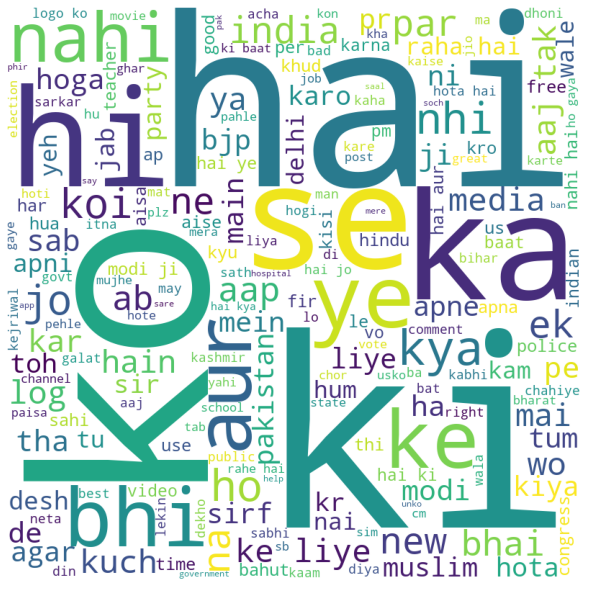

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(sl)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [ ]:
for ppol in ['hai','ki','se','nhi','india','ko','hi']:
  print(ppol,word_freq[ppol])

hai 8369
ki 4867
se 3161
nhi 1663
india 1205
ko 5031
hi 2386


## bar graph of the sentence length

<BarContainer object of 121 artists>

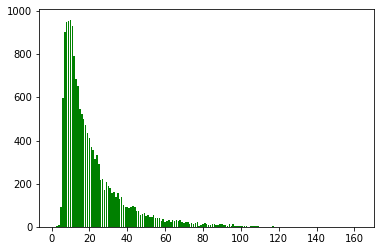

In [ ]:
plt.bar(len_of_sentence.keys(), len_of_sentence.values(), color='g')

In [ ]:
bv = 0
bx = None
for key,val in len_of_sentence.items():
  if(val>bv):
    bv = val
    bx = key

In [ ]:
print(bx,bv)

10 960


In [ ]:
len_of_sentence

In [ ]:
vocab_size = len(word_freq)

In [ ]:
len(word_freq)

28374

In [ ]:
train = tf.data.TextLineDataset("/content/drive/MyDrive/data/sentences_file.txt")

In [ ]:
def custom_standard(input_string):
    return tf.strings.lower(input_string)

In [ ]:
vectorize_layer = TextVectorization(
   standardize=custom_standard,
    max_tokens=int((99.5/100)*vocab_size),
    output_mode="int",
)

In [ ]:
vectorize_layer.adapt(train)

In [ ]:
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)

In [ ]:
ix_to_vocab = {}
for i in range(len(vocab)):
  ix_to_vocab[vocab[i]] = i

In [ ]:
vocab_size

28232

In [ ]:
def prepare_dataset(text):
    '''
    text = [1,2,3,4,5] seq_len = 4
    x = [1,2,3,4] y = [2,3,4,5]
    '''
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [ ]:
train_ds = train.map(prepare_dataset) # train_ds[0] = tuple(x[0],y[0])

In [ ]:
tokenised_sen = []
for i in train_ds:
  tokenised_sen.append(i.numpy().reshape(-1,))

In [ ]:
tokenised_sen[:2]

[array([  18,    4,  193,   19,   48,   28,  216,   87,  221,    5,  780,
        1054,   19,   13,  922, 1641, 3479,   16]),
 array([  716, 23307,     2,  6375,   160,    72,    25,  1336,   583])]

In [ ]:
def get_xy(tokenised_sen,maxlen,step):
  final_x = []
  final_y = []
  for d in tokenised_sen:
    l = d.shape[0]
    for i in range(0,l-maxlen-1,step):
      final_x.append(d[i:i+maxlen])
      final_y.append(d[i+1:i+maxlen+1])
  return np.array(final_x).reshape(len(final_x),len(final_x[0])),np.array(final_y).reshape(len(final_y),len(final_y[0]))

## building a custom datagenerator

In [ ]:
class TextDataGenerator(keras.utils.Sequence):
    def __init__(self, input, target, sequence_length, vocab_size, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.input = input
        self.target = target
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.input) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        #print(indexes)
        sequences_batch = [self.input[k] for k in indexes]
        next_words_batch = [self.target[k] for k in indexes]
        X = np.array(sequences_batch)
        y = keras.utils.to_categorical(next_words_batch, num_classes=self.vocab_size)
        # else:
        #   X, y = self.__data_generation(sequences_batch, next_words_batch)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.input))
        if self.shuffle == True:
           np.random.shuffle(self.indexes)

In [ ]:
def multi_lstm_model(sequence_length, vocab_size, layer_size,number_of_lstms=1, embedding=False):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, layer_size))
  for i in range(number_of_lstms):
    model.add(layers.LSTM(layer_size,return_sequences=True))    
    #model.add(layers.Dropout(0.3))
  model.add(layers.Dense(layer_size))
  model.add(layers.Dense(vocab_size, activation='softmax'))
  return model

In [ ]:
maxlen = 5 
step = 1
fx,fy = get_xy(tokenised_sen,maxlen,step)

In [ ]:
datagen51 = TextDataGenerator(fx,fy,maxlen,vocab_size,batch_size=512)

In [ ]:
mdl_1 = multi_lstm_model(sequence_length=5, vocab_size=vocab_size,layer_size=512,number_of_lstms=1)

optimizer = keras.optimizers.RMSprop(lr=0.01)
mdl_1.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
mdl_1 = keras.models.load_model('/content/drive/MyDrive/finally_final/mdl_1/20/model')

## model-1 summary and training 

In [ ]:
mdl_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 512)         14454784  
_________________________________________________________________
lstm_514 (LSTM)              (None, None, 512)         2099200   
_________________________________________________________________
dense_6 (Dense)              (None, None, 512)         262656    
_________________________________________________________________
dense_7 (Dense)              (None, None, 28232)       14483016  
Total params: 31,299,656
Trainable params: 31,299,656
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
478/478 [==============================] - 154s 254ms/step - loss: 2.5230
Epoch 2/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4516
Epoch 3/10
478/478 [==============================] - 123s 257ms/step - loss: 2.4404
Epoch 4/10
478/478 [==============================] - 121s 252ms/step - loss: 2.4319
Epoch 5/10
478/478 [==============================] - 121s 254ms/step - loss: 2.4245
Epoch 6/10
478/478 [==============================] - 120s 252ms/step - loss: 2.4249
Epoch 7/10
478/478 [==============================] - 121s 254ms/step - loss: 2.4188
Epoch 8/10
478/478 [==============================] - 123s 258ms/step - loss: 2.4146
Epoch 9/10
478/478 [==============================] - 123s 257ms/step - loss: 2.4144
Epoch 10/10
478/478 [==============================] - 123s 258ms/step - loss: 2.4120


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_1/30/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_1/30/model/assets


Epoch 1/10
478/478 [==============================] - 121s 253ms/step - loss: 2.4106
Epoch 2/10
478/478 [==============================] - 120s 252ms/step - loss: 2.4113
Epoch 3/10
478/478 [==============================] - 123s 256ms/step - loss: 2.4097
Epoch 4/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4092
Epoch 5/10
478/478 [==============================] - 122s 255ms/step - loss: 2.4090
Epoch 6/10
478/478 [==============================] - 121s 254ms/step - loss: 2.4109
Epoch 7/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4099
Epoch 8/10
478/478 [==============================] - 123s 257ms/step - loss: 2.4089
Epoch 9/10
478/478 [==============================] - 122s 255ms/step - loss: 2.4095
Epoch 10/10
478/478 [==============================] - 122s 255ms/step - loss: 2.4094


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_1/40/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_1/40/model/assets


Epoch 1/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4089
Epoch 2/10
478/478 [==============================] - 123s 257ms/step - loss: 2.4122
Epoch 3/10
478/478 [==============================] - 124s 259ms/step - loss: 2.4119
Epoch 4/10
478/478 [==============================] - 123s 258ms/step - loss: 2.4149
Epoch 5/10
478/478 [==============================] - 123s 256ms/step - loss: 2.4152
Epoch 6/10
478/478 [==============================] - 124s 258ms/step - loss: 2.4166
Epoch 7/10
478/478 [==============================] - 124s 258ms/step - loss: 2.4196
Epoch 8/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4170
Epoch 9/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4187
Epoch 10/10
478/478 [==============================] - 123s 257ms/step - loss: 2.4194


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_1/50/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_1/50/model/assets


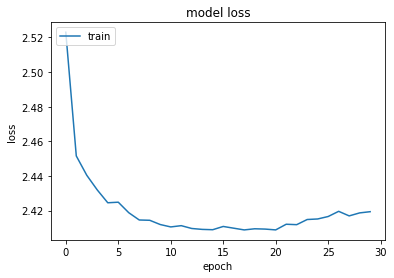

In [ ]:
loss_val = []
for i in range(2,5):
  hist = mdl_1.fit(datagen51,
          steps_per_epoch=len(datagen51),
          epochs=10,
          verbose=1)
  loss_val = loss_val+hist.history['loss']
  mdl_1.save("/content/drive/MyDrive/finally_final/mdl_1/"+str((i+1)*10)+"/model/")
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## model-2 summary and training 

In [ ]:
mdl_2 = multi_lstm_model(sequence_length=5, vocab_size=vocab_size,layer_size=512,number_of_lstms=2)

optimizer = keras.optimizers.RMSprop(lr=0.01)
mdl_2.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
mdl_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         14454784  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dense_2 (Dense)              (None, None, 512)         262656    
_________________________________________________________________
dense_3 (Dense)              (None, None, 28232)       14483016  
Total params: 33,398,856
Trainable params: 33,398,856
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
478/478 [==============================] - 127s 258ms/step - loss: 9.8801
Epoch 2/10
478/478 [==============================] - 125s 261ms/step - loss: 6.5234
Epoch 3/10
478/478 [==============================] - 125s 261ms/step - loss: 5.9174
Epoch 4/10
478/478 [==============================] - 121s 254ms/step - loss: 5.3043
Epoch 5/10
478/478 [==============================] - 124s 260ms/step - loss: 4.6579
Epoch 6/10
478/478 [==============================] - 124s 259ms/step - loss: 4.0512
Epoch 7/10
478/478 [==============================] - 122s 255ms/step - loss: 3.6251
Epoch 8/10
478/478 [==============================] - 124s 258ms/step - loss: 3.3452
Epoch 9/10
478/478 [==============================] - 123s 256ms/step - loss: 3.1427
Epoch 10/10
478/478 [==============================] - 122s 255ms/step - loss: 3.0005


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/10/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/10/model/assets


Epoch 1/10
478/478 [==============================] - 124s 259ms/step - loss: 2.9814
Epoch 2/10
478/478 [==============================] - 122s 255ms/step - loss: 2.8974
Epoch 3/10
478/478 [==============================] - 123s 258ms/step - loss: 2.8309
Epoch 4/10
478/478 [==============================] - 123s 257ms/step - loss: 2.7731
Epoch 5/10
478/478 [==============================] - 122s 254ms/step - loss: 2.7258
Epoch 6/10
478/478 [==============================] - 123s 257ms/step - loss: 2.6858
Epoch 7/10
478/478 [==============================] - 123s 258ms/step - loss: 2.6485
Epoch 8/10
478/478 [==============================] - 121s 252ms/step - loss: 2.6207
Epoch 9/10
478/478 [==============================] - 123s 257ms/step - loss: 2.5920
Epoch 10/10
478/478 [==============================] - 122s 255ms/step - loss: 2.5706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/20/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/20/model/assets


Epoch 1/10
478/478 [==============================] - 123s 257ms/step - loss: 2.5509
Epoch 2/10
478/478 [==============================] - 122s 255ms/step - loss: 2.5291
Epoch 3/10
478/478 [==============================] - 123s 258ms/step - loss: 2.5132
Epoch 4/10
478/478 [==============================] - 123s 257ms/step - loss: 2.5034
Epoch 5/10
478/478 [==============================] - 124s 259ms/step - loss: 2.4870
Epoch 6/10
478/478 [==============================] - 122s 256ms/step - loss: 2.4760
Epoch 7/10
478/478 [==============================] - 123s 257ms/step - loss: 2.4627
Epoch 8/10
478/478 [==============================] - 123s 256ms/step - loss: 2.4529
Epoch 9/10
478/478 [==============================] - 124s 258ms/step - loss: 2.4447
Epoch 10/10
478/478 [==============================] - 123s 256ms/step - loss: 2.4373


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/30/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/30/model/assets


Epoch 1/10
478/478 [==============================] - 126s 264ms/step - loss: 2.4280
Epoch 2/10
478/478 [==============================] - 127s 266ms/step - loss: 2.4181
Epoch 3/10
478/478 [==============================] - 126s 264ms/step - loss: 2.4117
Epoch 4/10
478/478 [==============================] - 127s 265ms/step - loss: 2.4040
Epoch 5/10
478/478 [==============================] - 125s 262ms/step - loss: 2.3967
Epoch 6/10
478/478 [==============================] - 127s 266ms/step - loss: 2.3931
Epoch 7/10
478/478 [==============================] - 124s 260ms/step - loss: 2.3900
Epoch 8/10
478/478 [==============================] - 126s 264ms/step - loss: 2.3859
Epoch 9/10
478/478 [==============================] - 127s 267ms/step - loss: 2.3765
Epoch 10/10
478/478 [==============================] - 126s 263ms/step - loss: 2.3735


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/40/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/40/model/assets


Epoch 1/10
478/478 [==============================] - 125s 261ms/step - loss: 2.3673
Epoch 2/10
478/478 [==============================] - 124s 259ms/step - loss: 2.3600
Epoch 3/10
478/478 [==============================] - 126s 263ms/step - loss: 2.3599
Epoch 4/10
478/478 [==============================] - 126s 264ms/step - loss: 2.3517
Epoch 5/10
478/478 [==============================] - 125s 262ms/step - loss: 2.3490
Epoch 6/10
478/478 [==============================] - 125s 261ms/step - loss: 2.3494
Epoch 7/10
478/478 [==============================] - 125s 262ms/step - loss: 2.3430
Epoch 8/10
478/478 [==============================] - 125s 260ms/step - loss: 2.3429
Epoch 9/10
478/478 [==============================] - 125s 261ms/step - loss: 2.3385
Epoch 10/10
478/478 [==============================] - 125s 262ms/step - loss: 2.3357


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/50/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_2/50/model/assets


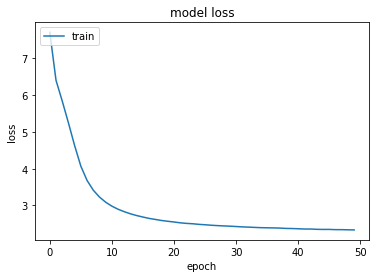

In [ ]:
loss_val2 = []
for i in range(5):
  hist = mdl_2.fit(datagen51,
          steps_per_epoch=len(datagen51),
          epochs=10,
          verbose=1)
  loss_val2 = loss_val2+hist.history['loss']
  mdl_2.save("/content/drive/MyDrive/finally_final/mdl_2/"+str((i+1)*10)+"/model/")
plt.plot(loss_val2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()